Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

Some additional reading:

* https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
* http://www.folgertkarsdorp.nl/word2vec-an-introduction/
* https://www.kaggle.com/c/word2vec-nlp-tutorial
* http://www.cs.toronto.edu/~bonner/courses/2014s/csc321/lectures/lec5.pdf
* http://www.cs.toronto.edu/~bonner/courses/2016s/csc321/webpages/lectures.htm
* http://radimrehurek.com/gensim/models/word2vec.html

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [16]:
%matplotlib inline

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name)).split()
    f.close()

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156])


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    basically, loop through the data taking a window of size `skip_window`
    to each side of each word and making all those words entries in a 
    `labels` vector corresponding (each of them) to the center value of
    the total window. that center value goes in the batch vector.
    `num_skips` is essentially counting the number of repetitions of a
    center word from the window and if it is less than twice the `skip_window`,
    not all the words from the surrounding context will be used when filling
    the labels vector
    """
    # let's keep track of where we are in the data
    global data_index
    # the batch size must be evenly divisible by the number of skips
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # how much data do we traverse per skip?
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # hold the data for the minibatch
    buffer = collections.deque(maxlen=span)
    # fill the buffer with the next `span` words of data
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            # find a target that isn't in our "avoid" list
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            # put the selected target in our list to avoid
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch_size = 8
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])
('    labels:', ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'])
('    labels:', ['originated', 'anarchism', 'term', 'a', 'of', 'originated', 'term', 'as'])


In [6]:
batch_size = 12
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse'])
('    labels:', ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of', 'abuse', 'term', 'first', 'of'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term'])
('    labels:', ['originated', 'a', 'anarchism', 'term', 'as', 'originated', 'of', 'term', 'a', 'of', 'as', 'abuse'])


In [7]:
batch_size = 16
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 3)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used'])
('    labels:', ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'against', 'first'])

with num_skips = 4 and skip_window = 3:
('    batch:', ['a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of', 'abuse', 'abuse', 'abuse', 'abuse'])
('    labels:', ['anarchism', 'of', 'as', 'term', 'first', 'originated', 'a', 'abuse', 'first', 'a', 'as', 'abuse', 'used', 'term', 'first', 'a'])


In [8]:
batch_size = 8
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])
('    labels:', ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'])
('    labels:', ['anarchism', 'a', 'term', 'originated', 'originated', 'as', 'of', 'term'])


Train a skip-gram model.

In [10]:
tf.random_uniform([2, 3])

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1      # How many words to consider left and right.
num_skips = 2        # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16    # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64   # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, 
                                                     softmax_biases, 
                                                     embed, 
                                                     train_labels, 
                                                     num_sampled, 
                                                     vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.084363
Nearest to this: gibraltar, tl, mutant, lucio, what, fullness, paraphrase, kenyatta,
Nearest to UNK: jung, sichuan, reissues, highlander, tenochtitl, chronologically, stabilization, falwell,
Nearest to such: density, applied, cisneros, taunted, towels, temptations, chinatown, kul,
Nearest to seven: valuables, stood, etiquette, meru, evangelista, shapur, allocated, mathieu,
Nearest to more: ronaldo, epics, eubacteria, mauretania, wycliffe, equated, irredentism, attract,
Nearest to was: dhimma, sharada, molten, fondly, lefebvre, dendritic, secant, tum,
Nearest to four: fragment, wff, leucine, certifications, shelves, frieza, personhood, ligand,
Nearest to see: remarking, copylefted, chisinau, shaun, retracted, queen, balmoral, cinematographer,
Nearest to nine: beth, connections, td, purdue, bioko, undesirable, parnell, disagreement,
Nearest to b: meccans, accommodate, korca, suddenly, pershing, paymaster, gabaa, taif,
Nearest to by: punjab, al

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

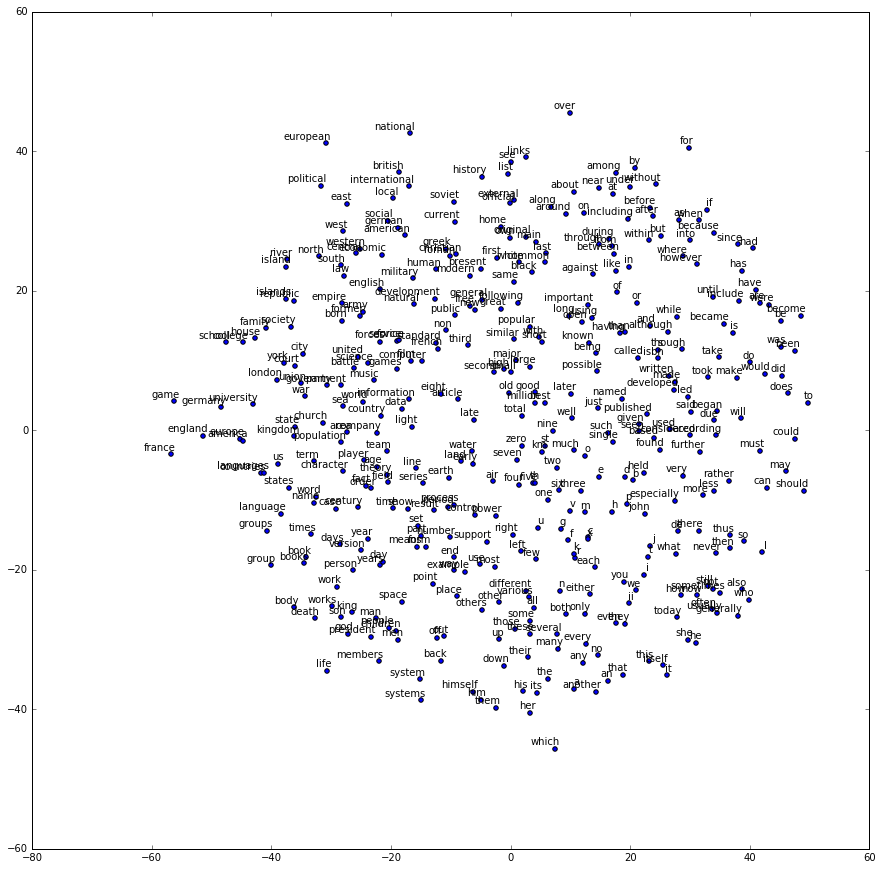

In [17]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---